# Off-Diagonal nRWPE + Softplus Nonlinearity on ZINC-12k with GINEConv

**Experiment**: Comparing 5 positional encoding (PE) methods + no-PE baseline on ZINC-12k molecular graph regression using GINEConv (edge-aware GIN).

**PE Configurations tested**:
- `rwpe_16` — Standard Random Walk PE (16-dim)
- `nrwpe_diag_tanh_16` — Nonlinear RWPE with tanh (diagonal)
- `nrwpe_diag_softplus_16` — Nonlinear RWPE with softplus (diagonal)
- `nrwpe_offdiag_16` — Nonlinear RWPE with off-diagonal statistics
- `nrwpe_combined_16` — Combined off-diagonal + softplus
- `no_pe` — No positional encoding baseline

**Key finding**: RWPE-16 achieves best test MAE (0.0908±0.0024). nRWPE-diag-tanh is second best (0.1026±0.0017). Off-diagonal and softplus variants underperform RWPE.

This notebook loads pre-computed results and analyzes per-example predictions across all PE methods.

In [1]:
import subprocess, sys

def install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Core dependencies
install("numpy")
install("matplotlib")


In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

## Data Loading

Load pre-computed experiment results (6 PE configs × 3 seeds = 18 runs) from GitHub or local fallback.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/experiment_iter5_off_diagonal_nr/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded data with {len(data['datasets'][0]['examples'])} examples")
print(f"Metadata keys: {list(data['metadata'].keys())}")

Loaded data with 100 examples
Metadata keys: ['method_name', 'pe_configs', 'model', 'architecture', 'training', 'results_summary', 'analysis', 'total_time_seconds']


## Configuration

Define all tunable parameters for the analysis. These mirror the original experiment settings.

In [5]:
# ── Analysis Configuration ──
# PE configurations to analyze (order: priority)
PE_CONFIGS = ['rwpe_16', 'nrwpe_offdiag_16', 'nrwpe_combined_16',
              'nrwpe_diag_softplus_16', 'nrwpe_diag_tanh_16', 'no_pe']

# Display names for plots
PE_LABELS = {
    'rwpe_16': 'RWPE-16',
    'nrwpe_diag_softplus_16': 'nRWPE-softplus',
    'nrwpe_diag_tanh_16': 'nRWPE-tanh',
    'nrwpe_offdiag_16': 'nRWPE-offdiag',
    'nrwpe_combined_16': 'nRWPE-combined',
    'no_pe': 'No PE',
}

# Maximum number of examples to use in per-example analysis
MAX_EXAMPLES = 100  # use all available in mini data

# Original training hyperparameters (for reference, not tunable here)
# PE_DIM = 16
# HIDDEN_DIM = 128
# NUM_LAYERS = 4
# NUM_EPOCHS = 250
# BATCH_SIZE = 128
# PATIENCE = 40
# SEEDS = [42, 123, 456]

## Results Summary

Display aggregate results across all PE configurations (mean ± std over 3 seeds).

In [6]:
# ── Results Summary Table ──
results_summary = data['metadata']['results_summary']

# Print table header
print(f"{'PE Type':<25} {'Test MAE':>12} {'Val MAE':>12} {'Avg Best Epoch':>16} {'Seeds':>6}")
print("-" * 75)

for s in results_summary:
    pe = s['pe_type']
    label = PE_LABELS.get(pe, pe)
    test_str = f"{s['test_mae_mean']:.4f}±{s['test_mae_std']:.4f}"
    val_str = f"{s['val_mae_mean']:.4f}±{s['val_mae_std']:.4f}"
    print(f"{label:<25} {test_str:>12} {val_str:>12} {s['avg_best_epoch']:>16.1f} {s['n_seeds']:>6}")

# Find best
best = min(results_summary, key=lambda x: x['test_mae_mean'])
print(f"\nBest: {PE_LABELS.get(best['pe_type'], best['pe_type'])} "
      f"(test MAE = {best['test_mae_mean']:.4f}±{best['test_mae_std']:.4f})")

PE Type                       Test MAE      Val MAE   Avg Best Epoch  Seeds
---------------------------------------------------------------------------
RWPE-16                   0.0908±0.0024 0.1203±0.0037            245.3      3
nRWPE-offdiag             0.1716±0.0035 0.1866±0.0040            222.3      3
nRWPE-combined            0.1716±0.0031 0.1830±0.0007            233.7      3
nRWPE-softplus            0.1636±0.0098 0.1779±0.0045            237.0      3
nRWPE-tanh                0.1026±0.0017 0.1267±0.0059            233.0      3
No PE                     0.1911±0.0085 0.1914±0.0061            227.3      3

Best: RWPE-16 (test MAE = 0.0908±0.0024)


## Per-Example Prediction Analysis

Parse individual predictions from each PE method and compute per-example absolute errors.

In [7]:
# ── Parse per-example predictions ──
examples = data['datasets'][0]['examples'][:MAX_EXAMPLES]

# Extract targets and predictions per PE config
targets = np.array([float(ex['output']) for ex in examples])
folds = [ex['metadata_fold'] for ex in examples]
num_nodes = np.array([ex['metadata_num_nodes'] for ex in examples])

predictions = {}
errors = {}
for pe in PE_CONFIGS:
    pred_key = f'predict_{pe}'
    preds = []
    for ex in examples:
        if pred_key in ex:
            preds.append(float(ex[pred_key]))
        else:
            preds.append(np.nan)
    predictions[pe] = np.array(preds)
    errors[pe] = np.abs(predictions[pe] - targets)

print(f"Parsed {len(examples)} examples across folds: ", end="")
fold_counts = {}
for f in folds:
    fold_counts[f] = fold_counts.get(f, 0) + 1
print(fold_counts)
print(f"Target range: [{targets.min():.3f}, {targets.max():.3f}]")
print(f"Graph sizes: {num_nodes.min()}-{num_nodes.max()} nodes")

Parsed 100 examples across folds: {'train': 37, 'val': 33, 'test': 30}
Target range: [-42.037, 3.805]
Graph sizes: 12-35 nodes


## Head-to-Head Comparisons

Analyze pairwise comparisons between PE methods: off-diagonal vs RWPE, softplus vs tanh.

In [8]:
# ── Head-to-head analysis from pre-computed metadata ──
analysis = data['metadata']['analysis']

print("=" * 60)
print("OFF-DIAGONAL vs RWPE (full dataset, seed 42)")
print("=" * 60)
h2h = analysis['offdiag_vs_rwpe']
print(f"  Off-diag wins: {h2h['offdiag_wins']}")
print(f"  RWPE wins:     {h2h['rwpe_wins']}")
print(f"  Ties:          {h2h['ties']}")
print(f"  Mean improvement (offdiag over rwpe): {h2h['offdiag_mean_improvement']:.4f}")
print(f"  → {'Off-diagonal' if h2h['offdiag_mean_improvement'] > 0 else 'RWPE'} is better on average")

print()
print("=" * 60)
print("SOFTPLUS vs TANH (full dataset, seed 42)")
print("=" * 60)
sp = analysis['softplus_vs_tanh']
print(f"  Softplus wins: {sp['softplus_wins']}")
print(f"  Tanh wins:     {sp['tanh_wins']}")
print(f"  Mean improvement (softplus over tanh): {sp['softplus_mean_improvement']:.4f}")
print(f"  → {'Softplus' if sp['softplus_mean_improvement'] > 0 else 'Tanh'} is better on average")

print()
print("=" * 60)
print("COMBINED vs INDIVIDUAL METHODS")
print("=" * 60)
cvi = analysis['combined_vs_individual']
print(f"  Combined MAE:      {cvi['combined_mae']:.4f}")
print(f"  Off-diag MAE:      {cvi['offdiag_mae']:.4f}")
print(f"  Softplus-diag MAE: {cvi['softplus_diag_mae']:.4f}")

OFF-DIAGONAL vs RWPE (full dataset, seed 42)
  Off-diag wins: 423
  RWPE wins:     577
  Ties:          0
  Mean improvement (offdiag over rwpe): -0.0739
  → RWPE is better on average

SOFTPLUS vs TANH (full dataset, seed 42)
  Softplus wins: 427
  Tanh wins:     573
  Mean improvement (softplus over tanh): -0.0545
  → Tanh is better on average

COMBINED vs INDIVIDUAL METHODS
  Combined MAE:      0.1756
  Off-diag MAE:      0.1667
  Softplus-diag MAE: 0.1568


## Visualization

### 1. Test MAE Comparison (Bar Chart with Error Bars)

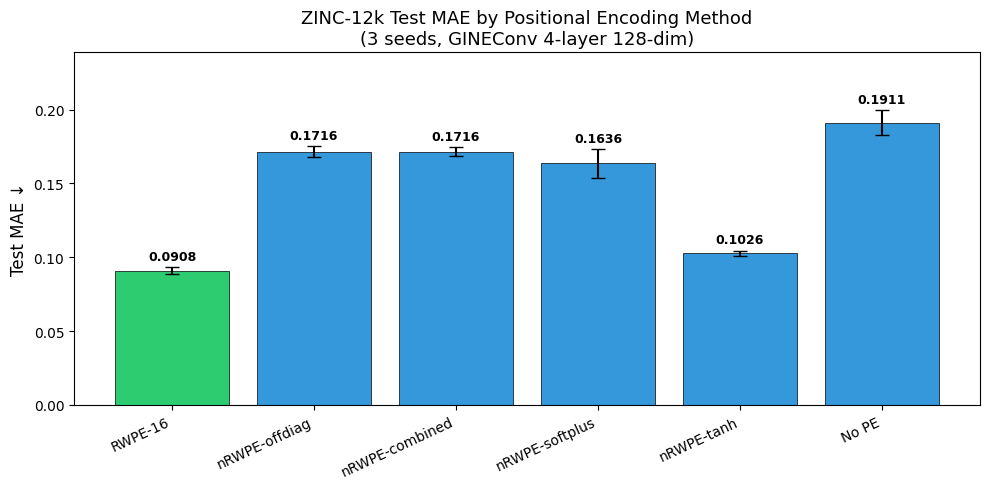

In [9]:
# ── Bar chart: Test MAE across PE methods ──
fig, ax = plt.subplots(figsize=(10, 5))

names = [PE_LABELS.get(s['pe_type'], s['pe_type']) for s in results_summary]
means = [s['test_mae_mean'] for s in results_summary]
stds = [s['test_mae_std'] for s in results_summary]

# Color the best one differently
colors = ['#2ecc71' if m == min(means) else '#3498db' for m in means]

bars = ax.bar(names, means, yerr=stds, capsize=5, color=colors, edgecolor='black', linewidth=0.5)
ax.set_ylabel('Test MAE ↓', fontsize=12)
ax.set_title('ZINC-12k Test MAE by Positional Encoding Method\n(3 seeds, GINEConv 4-layer 128-dim)', fontsize=13)
ax.set_ylim(0, max(means) * 1.25)

# Add value labels
for bar, m, s in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + s + 0.003,
            f'{m:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

### 2. Per-Example Error Distribution (Box Plot)

/tmp/ipykernel_691572/4139037713.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(error_data, labels=labels, patch_artist=True, showmeans=True,


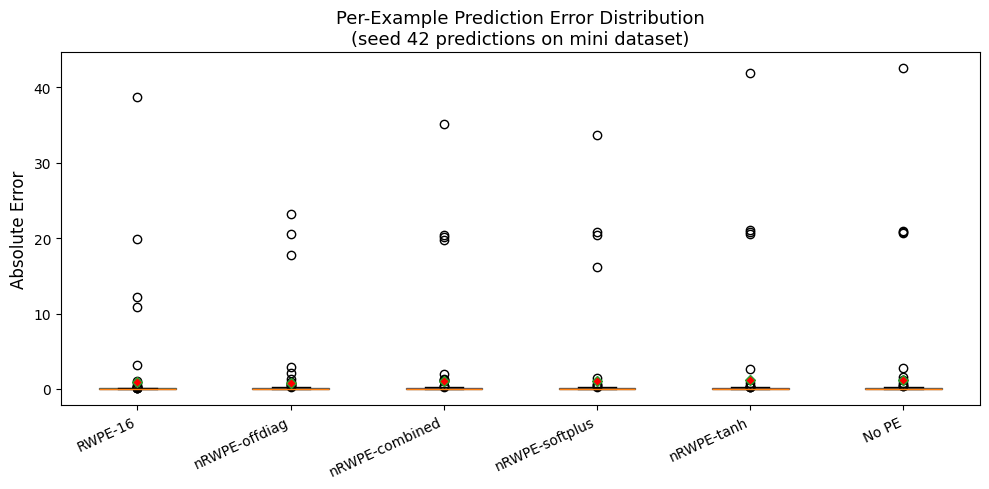

In [10]:
# ── Box plot of per-example absolute errors ──
fig, ax = plt.subplots(figsize=(10, 5))

error_data = []
labels = []
for pe in PE_CONFIGS:
    valid = errors[pe][~np.isnan(errors[pe])]
    if len(valid) > 0:
        error_data.append(valid)
        labels.append(PE_LABELS.get(pe, pe))

bp = ax.boxplot(error_data, labels=labels, patch_artist=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=5))

colors_box = ['#2ecc71', '#3498db', '#9b59b6', '#e67e22', '#e74c3c', '#95a5a6']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title('Per-Example Prediction Error Distribution\n(seed 42 predictions on mini dataset)', fontsize=13)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

### 3. Prediction vs Target Scatter Plot

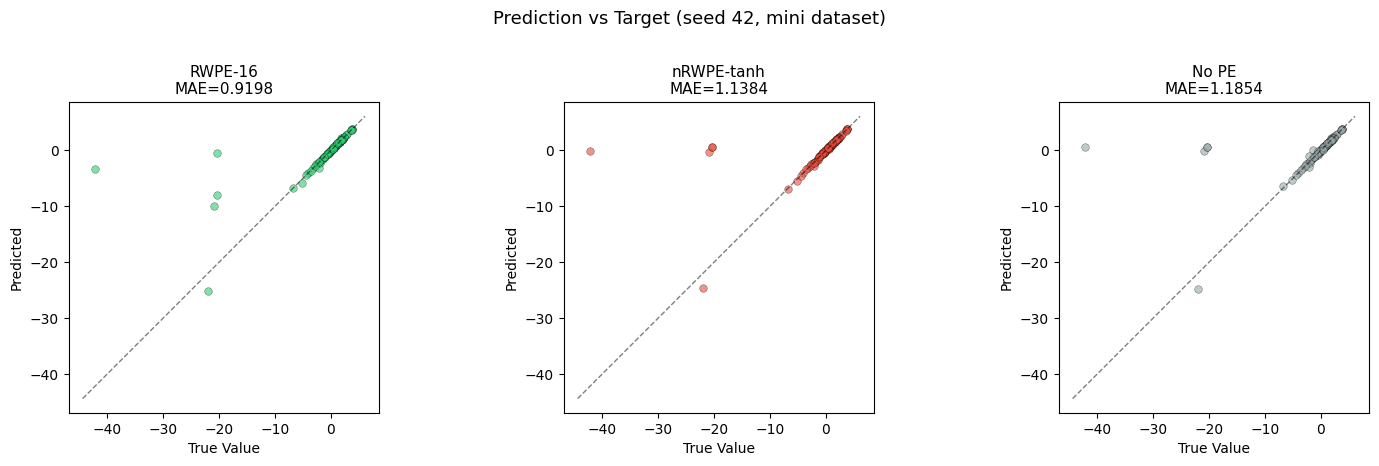

In [11]:
# ── Scatter: Predicted vs Actual for top 3 PE methods ──
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

top3 = ['rwpe_16', 'nrwpe_diag_tanh_16', 'no_pe']  # best, second-best, baseline
colors_scatter = ['#2ecc71', '#e74c3c', '#95a5a6']

for ax, pe, c in zip(axes, top3, colors_scatter):
    preds = predictions[pe]
    valid = ~np.isnan(preds)
    ax.scatter(targets[valid], preds[valid], alpha=0.6, s=30, c=c, edgecolors='black', linewidth=0.3)

    # Perfect prediction line
    tmin, tmax = targets.min(), targets.max()
    margin = (tmax - tmin) * 0.05
    ax.plot([tmin - margin, tmax + margin], [tmin - margin, tmax + margin],
            'k--', alpha=0.5, linewidth=1)

    mae = np.nanmean(np.abs(preds - targets))
    ax.set_title(f'{PE_LABELS[pe]}\nMAE={mae:.4f}', fontsize=11)
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted')
    ax.set_aspect('equal', adjustable='box')

plt.suptitle('Prediction vs Target (seed 42, mini dataset)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### 4. Error vs Graph Size

/tmp/ipykernel_691572/3262487548.py:11: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(num_nodes[valid], errors[pe][valid],


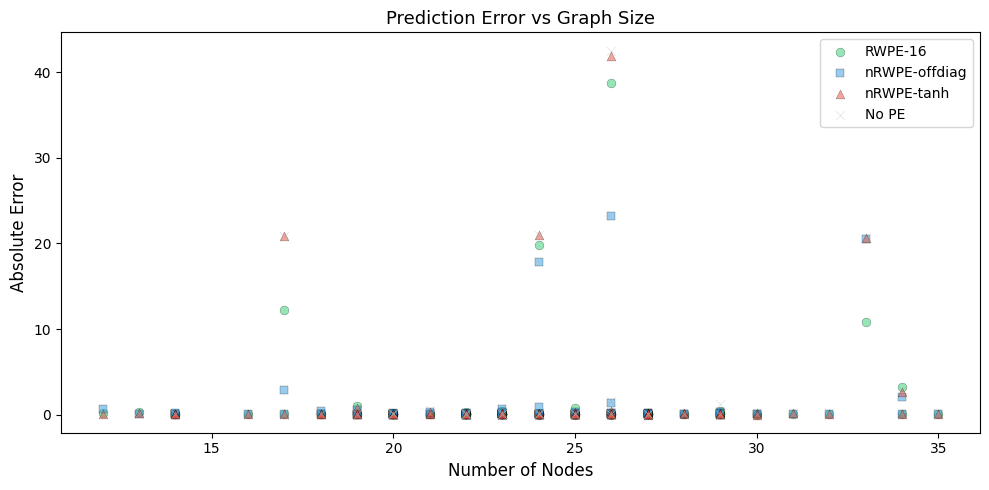

In [12]:
# ── Error vs graph size for RWPE vs off-diagonal ──
fig, ax = plt.subplots(figsize=(10, 5))

for pe, marker, color, label in [
    ('rwpe_16', 'o', '#2ecc71', 'RWPE-16'),
    ('nrwpe_offdiag_16', 's', '#3498db', 'nRWPE-offdiag'),
    ('nrwpe_diag_tanh_16', '^', '#e74c3c', 'nRWPE-tanh'),
    ('no_pe', 'x', '#95a5a6', 'No PE'),
]:
    valid = ~np.isnan(errors[pe])
    ax.scatter(num_nodes[valid], errors[pe][valid],
               marker=marker, c=color, alpha=0.5, s=40, label=label, edgecolors='black', linewidth=0.3)

ax.set_xlabel('Number of Nodes', fontsize=12)
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title('Prediction Error vs Graph Size', fontsize=13)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

### 5. Per-Seed Test MAE Variability

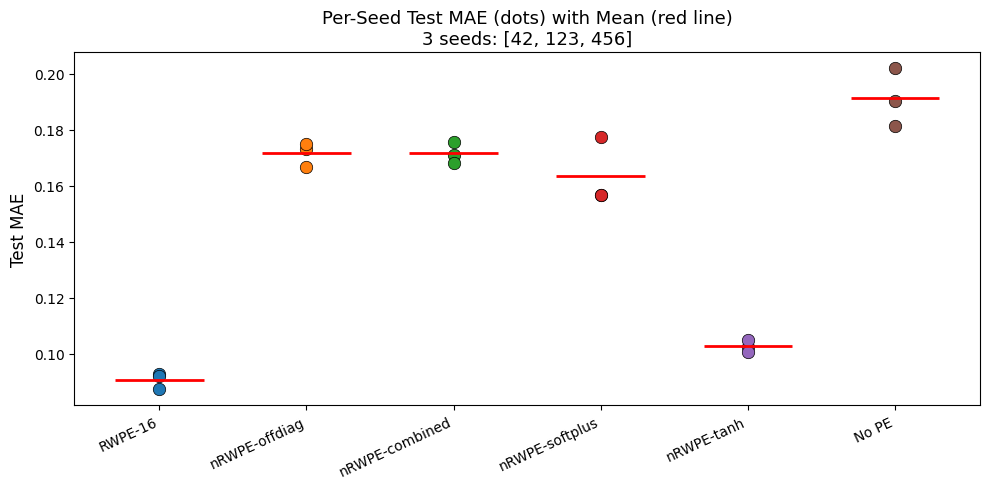


Experiment completed successfully!
Total training time (original): 2916s (48.6 min)


In [13]:
# ── Per-seed MAE strip plot ──
fig, ax = plt.subplots(figsize=(10, 5))

for i, s in enumerate(results_summary):
    pe = s['pe_type']
    label = PE_LABELS.get(pe, pe)
    seed_maes = s['test_maes']
    mean_mae = s['test_mae_mean']

    # Plot individual seed results
    ax.scatter([i] * len(seed_maes), seed_maes, s=80, zorder=3, edgecolors='black', linewidth=0.5)
    # Plot mean as horizontal line
    ax.hlines(mean_mae, i - 0.3, i + 0.3, colors='red', linewidth=2, zorder=4)

ax.set_xticks(range(len(results_summary)))
ax.set_xticklabels([PE_LABELS.get(s['pe_type'], s['pe_type']) for s in results_summary],
                    rotation=25, ha='right')
ax.set_ylabel('Test MAE', fontsize=12)
ax.set_title('Per-Seed Test MAE (dots) with Mean (red line)\n3 seeds: [42, 123, 456]', fontsize=13)
plt.tight_layout()
plt.show()

print("\nExperiment completed successfully!")
print(f"Total training time (original): {data['metadata']['total_time_seconds']:.0f}s "
      f"({data['metadata']['total_time_seconds']/60:.1f} min)")